# CHess RL Torch

In [1]:
import os

In [2]:
import math
import random
import time

In [3]:
from tqdm import tqdm

In [4]:
import chess
import numpy as np

In [5]:
from collections import defaultdict

In [6]:
import matplotlib.pyplot as plt

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Se está utilizando el dispositivo',device)

Se está utilizando el dispositivo cuda


Definimos el ambiente del juego y las respectivas reglas:

In [9]:
def board_to_tensor(board):
    piece_map = board.piece_map()
    board_tensor = np.zeros((12, 8, 8), dtype=np.float32)

    for pos, piece in piece_map.items():
        rank, file = chess.square_rank(pos), chess.square_file(pos)
        piece_idx = piece.piece_type - 1 + (6 if piece.color == chess.BLACK else 0)
        board_tensor[piece_idx, rank, file] = 1

    return board_tensor


In [10]:
class ChessEnvironment:
    def __init__(self):
        self.board = chess.Board()
        
    def reset(self):
        self.board.reset()
        return self.board_to_array(self.board)
    
    def board_to_array(self, board):
        # Convierte el tablero en una matriz 8x8x12 que representa las piezas y sus posiciones.
        piece_symbols = "PRNBQKprnbqk"
        piece_indices = {symbol: i for i, symbol in enumerate(piece_symbols)}
        board_matrix = np.zeros((12, 8, 8))

        for i in range(64):
            piece = board.piece_at(i)
            if piece:
                piece_index = piece_indices[piece.symbol()]
                row, col = divmod(i, 8)
                board_matrix[piece_index, row, col] = 1

        return board_matrix

    def step(self, move):
        # Aplicar el movimiento al tablero y devolver el nuevo estado, recompensa y si el juego ha terminado.
        game_over = False
        reward = 0

        if move in self.legal_moves():
            self.board.push(move)
            game_over = self.board.is_game_over()
            if game_over:
                reward = self.get_reward()
        else:
            raise ValueError("Illegal move")

        next_state = self.board_to_array(self.board)
        return next_state, reward, game_over

    def legal_moves(self):
        return list(self.board.legal_moves)

    # def is_game_over(self):
    #     return self.board.is_game_over()
    def is_game_over(self):  # Modifica la función para que no requiera argumentos adicionales
        return self.board.is_game_over()

    def get_reward(self):
        result = self.board.result()
        if result == "1-0":  # White wins
            return 1
        elif result == "0-1":  # Black wins
            return -1
        else:  # Draw
            return 0
    
    def get_state(self):
        return board_to_tensor(self.board)

Creamos la red neuronal:

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

class ChessNetwork(nn.Module):
    def __init__(self, num_residual_blocks=3, num_channels=256):
        super(ChessNetwork, self).__init__()

        self.conv_input = nn.Conv2d(12, num_channels, kernel_size=3, stride=1, padding=1)
        self.bn_input = nn.BatchNorm2d(num_channels)

        self.residual_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_residual_blocks)])

        self.conv_policy = nn.Conv2d(num_channels, 2, kernel_size=1)
        self.bn_policy = nn.BatchNorm2d(2)
        self.fc_policy = nn.Linear(2 * 8 * 8, 4096)  # 4096 es el número máximo de movimientos legales en ajedrez

        self.conv_value = nn.Conv2d(num_channels, 1, kernel_size=1)
        self.bn_value = nn.BatchNorm2d(1)
        self.fc_value1 = nn.Linear(8 * 8, 256)
        self.fc_value2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.bn_input(self.conv_input(x)))
        x = self.residual_blocks(x)

        policy = F.relu(self.bn_policy(self.conv_policy(x)))
        policy = policy.view(-1, 2 * 8 * 8)
        policy = F.softmax(self.fc_policy(policy), dim=-1)

        value = F.relu(self.bn_value(self.conv_value(x)))
        value = value.view(-1, 8 * 8)
        value = F.relu(self.fc_value1(value))
        value = torch.tanh(self.fc_value2(value))

        return policy, value

In [12]:
class ChessNetworkreduced(nn.Module):
    def __init__(self, num_residual_blocks=1, num_channels=64):
        super(ChessNetworkreduced, self).__init__()

        self.conv_input = nn.Conv2d(12, num_channels, kernel_size=3, stride=1, padding=1)
        self.bn_input = nn.BatchNorm2d(num_channels)

        self.residual_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_residual_blocks)])

        self.conv_policy = nn.Conv2d(num_channels, 2, kernel_size=1)
        self.bn_policy = nn.BatchNorm2d(2)
        self.fc_policy = nn.Linear(2 * 8 * 8, 4096)  # 4096 es el número máximo de movimientos legales en ajedrez

        self.conv_value = nn.Conv2d(num_channels, 1, kernel_size=1)
        self.bn_value = nn.BatchNorm2d(1)
        self.fc_value1 = nn.Linear(8 * 8, 256)
        self.fc_value2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.bn_input(self.conv_input(x)))
        x = self.residual_blocks(x)

        policy = F.relu(self.bn_policy(self.conv_policy(x)))
        policy = policy.view(-1, 2 * 8 * 8)
        policy = F.softmax(self.fc_policy(policy), dim=-1)

        value = F.relu(self.bn_value(self.conv_value(x)))
        value = value.view(-1, 8 * 8)
        value = F.relu(self.fc_value1(value))
        value = torch.tanh(self.fc_value2(value))

        return policy, value


Entrenamiento del modelo

In [13]:
class MCTSNode:
    def __init__(self, parent, prior, action):
        self.parent = parent
        self.action = action
        self.visit_count = 0
        self.value_sum = 0
        self.children = {}
        self.prior = prior

    def expand(self, env, action_probs):
        for move, prob in action_probs.items():
            if move not in self.children:
                self.children[move] = MCTSNode(self, prob, move)

    def is_expanded(self):
        return len(self.children) > 0

    def select_child(self):
        C = 1.0  # Parámetro de exploración
        best_score = None
        best_action = None
        best_child = None

        for action, child in self.children.items():
            score = child.get_ucb_score(C)
            if best_score is None or score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def get_ucb_score(self, C):
        Q = self.value()  # Valor medio
        U = C * self.prior * math.sqrt(self.parent.visit_count) / (1 + self.visit_count)  # Potencial de mejora
        return Q + U

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def backpropagate(self, value):
        if self.parent is not None:
            self.parent.backpropagate(value)
        self.visit_count += 1
        self.value_sum += value


In [14]:
def move_to_index(move):
    from_square = move.from_square
    to_square = move.to_square
    return from_square * 64 + to_square

def index_to_move(index):
    from_square = index // 64
    to_square = index % 64
    return chess.Move(from_square, to_square)

In [15]:
def run_mcts(model, env, num_simulations, temperature):
    root = MCTSNode(None, 1.0, None)

    for _ in range(num_simulations):
        node = root
        board_copy = env.board.copy()

        # Selección y expansión
        while node.is_expanded():
            action, node = node.select_child()
            board_copy.push(action)

        # Simulación
        if not env.is_game_over():
            legal_moves = list(board_copy.legal_moves)
            state = env.board_to_array(board_copy)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            policy, value = model(state_tensor)
            policy = policy.cpu().detach().numpy().flatten()

            if len(legal_moves) > 0:  # Verifica si hay al menos un movimiento legal
                action_probs = {move: policy[move_to_index(move)] for move in legal_moves}
                node.expand(env, action_probs)
            else:
                action_probs = {}  # Inicializa un diccionario vacío si no hay movimientos legales

            value = value.item()
        else:
            value = env.get_reward(board_copy)

        # Retroceso
        node.backpropagate(value)

    # Calcula la política final a partir del número de visitas de las acciones.
    legal_moves = list(env.board.legal_moves)  # Añade esta línea para obtener una lista de movimientos legales
    visit_counts = np.array([root.children.get(action, 0).visit_count for action in legal_moves])  # Itera sobre los movimientos legales en lugar de usar num_legal_moves

    if temperature == 0:
        action_idx = np.argmax(visit_counts)
        policy = np.zeros_like(visit_counts)
        policy[action_idx] = 1
    else:
        visit_counts = visit_counts ** (1 / temperature)
        policy = visit_counts / visit_counts.sum()

    return policy

In [16]:
import chess.pgn

def load_games_from_pgn(pgn_file, max_games=None):
    games = []
    with open(pgn_file, "r") as pgn:
        for _ in tqdm(range(max_games) if max_games else tqdm(pgn)):
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)
            if max_games and len(games) >= max_games:
                break
    return games

In [17]:
def play_game(model, env, game, num_mcts_simulations, temperature, return_result=False):
    states = []
    policy_targets = []
    value_targets = []

    for move in game.mainline_moves():
        if not env.board.is_game_over():
            policy = run_mcts(model, env, num_mcts_simulations, temperature)

            legal_moves = list(env.legal_moves())  
            if len(legal_moves) > 0:  
                env.board.push(move)
                states.append(env.get_state().copy())

                padded_policy = np.zeros(4096)
                padded_policy[:len(policy)] = policy
                policy_targets.append(padded_policy)

    result = env.board.result()

    if result == "1-0":
        value_targets = [1] * len(states)
    elif result == "0-1":
        value_targets = [-1] * len(states)
    else:
        value_targets = [0] * len(states)

    if return_result:
        return result
    else:
        return states, policy_targets, value_targets

In [18]:
def play_games(model, games, num_mcts_simulations=8, temperature=1.0):
    states, policy_targets, value_targets = [], [], []

    for game in games:
        env = ChessEnvironment()
        game_states, game_policies, game_values = play_game(model, env, game, num_mcts_simulations, temperature)
        states.extend(game_states)
        policy_targets.extend(game_policies)
        value_targets.extend(game_values)

    return states, policy_targets, value_targets


In [19]:
def compute_loss(model, states, policy_targets, value_targets, device):
    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    policy_targets = torch.tensor(np.array(policy_targets), dtype=torch.float32).to(device)
    value_targets = torch.tensor(np.array(value_targets), dtype=torch.float32).to(device)

    policies, values = model(states)

    # Utilizar nll_loss en lugar de binary_cross_entropy
    policy_loss = F.nll_loss(torch.log(policies), torch.argmax(policy_targets, dim=1))
    value_loss = F.mse_loss(values.view(-1), value_targets)

    total_loss = policy_loss + value_loss

    return total_loss


In [20]:
def evaluate_game(model, env, num_mcts_simulations):
    while not env.is_game_over():
        state = env.board_to_array(env.board)
        policy, _ = run_mcts(model, env, num_mcts_simulations, temperature=0)

        action = np.argmax(policy)
        legal_moves = list(env.legal_moves())
        move = legal_moves[action]

        env.step(move)

    return env.get_reward()

In [21]:
# def evaluate_and_save_model(model, save_dir="saved_models", num_evaluation_games=100, num_mcts_simulations=800):
def evaluate_and_save_model(model, save_dir="saved_models", num_evaluation_games=10, num_mcts_simulations=8):
    win_count = 0
    draw_count = 0
    loss_count = 0

    for _ in range(num_evaluation_games):
        env = ChessEnvironment()
        game_result = evaluate_game(model, env, num_mcts_simulations)

        if game_result == 1:
            win_count += 1
        elif game_result == 0:
            draw_count += 1
        else:
            loss_count += 1

    win_rate = win_count / num_evaluation_games
    draw_rate = draw_count / num_evaluation_games
    loss_rate = loss_count / num_evaluation_games

    print(f"Evaluation results: {num_evaluation_games} games played")
    print(f"Win rate: {win_rate:.2f}, Draw rate: {draw_rate:.2f}, Loss rate: {loss_rate:.2f}")

    # Guardar el modelo si es mejor que el modelo anteriormente guardado.
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = os.path.join(save_dir, f"model_win_rate_{win_rate:.2f}.pt")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

In [22]:
def evaluate(model, num_games=10):
    model.eval()  # Cambiar el modelo a modo de evaluación.

    num_wins = 0
    num_draws = 0
    num_losses = 0
    for _ in range(num_games):
        env = ChessEnvironment()
        
        game = chess.pgn.Game()
        # game_result = play_game(model, env, num_mcts_simulations=50, temperature=0)
        game_result = play_game(model, env, game, num_mcts_simulations=50, temperature=0, return_result=True)

        if game_result == "1-0":
            num_wins += 1
        elif game_result == "0-1":
            num_losses += 1
        elif game_result == "1/2-1/2":
            num_draws += 1

    win_rate = num_wins / num_games
    draw_rate = num_draws / num_games
    loss_rate = num_losses / num_games

    return win_rate, draw_rate, loss_rate


In [23]:
def train(model, optimizer, epochs, evaluation_interval):
    losses = []
    min_loss = float("inf")
    min_epoch = 0  # Época en la que se alcanzó el mínimo de pérdida.
    
    progress_bar = tqdm(range(epochs))  # Guarda el objeto tqdm en la variable progress_bar

    for epoch in progress_bar:
        # Generar partidas de autojugabilidad.
        states, actions, rewards = play_games(model)
        
        # Calcular la pérdida y actualizar los pesos de la red neuronal.
        loss = compute_loss(model, states, actions, rewards, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Añadir la pérdida a la lista de pérdidas.
        losses.append(loss.item())

        # Evaluar y guardar el modelo en intervalos regulares.
        if (epoch + 1) % evaluation_interval == 0:
            win_rate, draw_rate, loss_rate = evaluate(model)
            print(f"Evaluation results: {evaluation_interval} games played")
            print(f"Win rate: {win_rate:.2f}, Draw rate: {draw_rate:.2f}, Loss rate: {loss_rate:.2f}")

            if loss.item() < min_loss:
                min_loss = loss.item()
                torch.save(model.state_dict(), f"saved_models\model_win_rate_{win_rate:.2f}.pt")
                min_epoch = epoch

        # Actualizar la barra de progreso con la información de la época actual y la pérdida.
        progress_bar.set_description(f"Epoch {epoch}, Loss {loss.item():.4f}")
    
    # Graficar la pérdida a lo largo de las épocas.
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    
    # Indicar dónde se alcanzó el mínimo de pérdida.
    plt.axvline(x=min_epoch, color='r', linestyle='--')
    plt.text(min_epoch, min_loss, f"Min Loss: {min_loss:.4f}", color='r')
    plt.show()

In [24]:
# Cargamos la base de datos
pgn_file = "C:/Users/mated/Documents/GitHub/CHESS_DATA/lichess_db_standard_rated_2013-01.pgn"

# games = load_games_from_pgn(pgn_file, max_games=1000)
games = load_games_from_pgn(pgn_file) # Extrae el número todal de juegos

121332it [04:57, 408.01it/s]
121332it [04:57, 408.01it/s]


In [25]:
print('Una partida cargada es:',list( games[0])[0])

Una partida cargada es: 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8#


In [26]:
# Crear el modelo
model = ChessNetworkreduced(num_residual_blocks=3, num_channels=64).to(device)

In [27]:
from torchsummary import summary

# Asume un tablero de ajedrez de 8x8 y 12 canales, que representan las diferentes piezas
input_shape = (12, 8, 8)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]           6,976
       BatchNorm2d-2             [-1, 64, 8, 8]             128
            Conv2d-3             [-1, 64, 8, 8]          36,928
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
     ResidualBlock-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
           Conv2d-10             [-1, 64, 8, 8]          36,928
      BatchNorm2d-11             [-1, 64, 8, 8]             128
    ResidualBlock-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
      BatchNorm2d-14             [-1, 6

In [28]:
optimizer = optim.Adam(model.parameters())

In [29]:
# Entrenar el modelo
epochs = 20
evaluation_interval = 5

In [30]:
# %timeit train(model, optimizer, epochs, evaluation_interval)

In [31]:
num_epochs = 20
evaluation_interval = 5
num_mcts_simulations = 50
learning_rate = 1e-3
batch_size = 32
num_games = 1000

# Optmizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

min_epoch = 0

loss_history = []

# Envolver el rango de épocas con tqdm para mostrar una barra de progreso
for epoch in tqdm(range(num_epochs), desc="Training"):
    st = time.time()
    epoch_losses = []
    
    # Aqui debe ir la seleccion aleatoria de N juegos de la lista de juegos games
    print('Cargando la muestra de {} juegos'.format(num_games))
    sample_games = random.sample(games, num_games)
    
    print('Procesando los juegos...')
    states, policy_targets, value_targets = play_games(model, sample_games, num_mcts_simulations=8, temperature=1.0)
    dataset = TensorDataset(
        torch.tensor(np.array(states), dtype=torch.float32),
        torch.tensor(np.array(policy_targets), dtype=torch.float32),
        torch.tensor(np.array(value_targets), dtype=torch.float32)
    )
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f'La carga de datos tardó {time.time()-st:.2f} s')
    
    print('Entrenamienot...')
    model.train()
    pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}")
    for state_batch, policy_target_batch, value_target_batch in pbar:
        optimizer.zero_grad()
        loss = compute_loss(model, state_batch, policy_target_batch, value_target_batch, device)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"Loss": loss.item()})
        epoch_losses.append(loss.item())
        

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")
    
    min_loss = min(loss_history)

    if (epoch + 1) % evaluation_interval == 0:
        win_rate, draw_rate, loss_rate = evaluate(model)
        print(f"Epoch {epoch + 1}, Win rate: {win_rate:.2f}, Draw rate: {draw_rate:.2f}, Loss rate: {loss_rate:.2f}")

        if win_rate + draw_rate > min_loss:
            min_loss = win_rate + draw_rate
            min_epoch = epoch + 1
            torch.save(model.state_dict(), f"saved_models/model_epoch_{epoch + 1}_win_rate_{win_rate:.2f}_draw_rate_{draw_rate:.2f}.pt")
            print(f"Model saved at epoch {epoch + 1}")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 1920.00 s
Entrenamienot...


Training:   5%|▌         | 1/20 [32:27<10:16:35, 1947.15s/it]

Epoch 1, Loss: 3.074661058898469
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 2182.42 s
Entrenamienot...


Training:  10%|█         | 2/20 [1:10:07<10:39:27, 2131.50s/it]

Epoch 2, Loss: 3.391339707631899
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 2189.77 s
Entrenamienot...


Training:  15%|█▌        | 3/20 [1:47:59<10:22:00, 2195.35s/it]

Epoch 3, Loss: 3.394744380085326
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 1797.02 s
Entrenamienot...


Training:  20%|██        | 4/20 [2:19:15<9:11:49, 2069.32s/it] 

Epoch 4, Loss: nan
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 1809.66 s
Entrenamienot...


Training:  25%|██▌       | 5/20 [2:50:45<8:21:10, 2004.68s/it]

Epoch 5, Loss: nan
Epoch 5, Win rate: 0.00, Draw rate: 0.00, Loss rate: 0.00
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 1652.85 s
Entrenamienot...


Training:  30%|███       | 6/20 [3:19:37<7:26:08, 1912.04s/it]

Epoch 6, Loss: nan
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 1867.11 s
Entrenamienot...


Training:  35%|███▌      | 7/20 [3:52:00<6:56:29, 1922.27s/it]

Epoch 7, Loss: nan
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 1675.71 s
Entrenamienot...


Training:  40%|████      | 8/20 [4:21:07<6:13:16, 1866.42s/it]

Epoch 8, Loss: nan
Cargando la muestra de 1000 juegos
Procesando los juegos...
La carga de datos tardó 2163.84 s
Entrenamienot...


Training:  45%|████▌     | 9/20 [4:58:29<6:03:40, 1983.65s/it]

Epoch 9, Loss: nan
Cargando la muestra de 1000 juegos
Procesando los juegos...


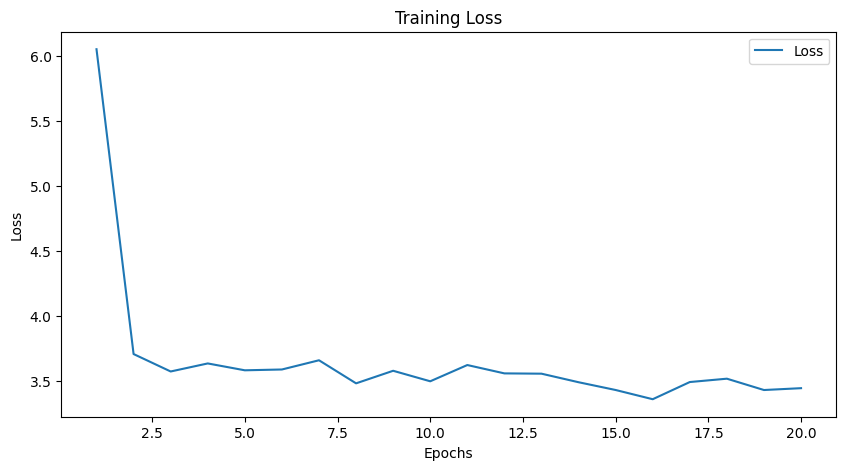

In [ ]:
print(f"Best model found at epoch {min_epoch}")

# Graficar la pérdida en función de las épocas
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history, label="Loss")
plt.scatter(min_epoch, loss_history[min_epoch - 1], color='red', label=f"Min Loss at Epoch {min_epoch}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.show()